# Import All Needed Libraries

In [55]:
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score
import numpy as np

%load_ext autoreload
%autoreload 2

from src.ATR import atr_wilder
from src.RSI import rsi_wilder
from src.VWAP import vwap
from src.MACD import macd
from src.SR import support_resistance


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
# Load Csv
df = pd.read_csv("data/btcusd_120-min_data.csv", parse_dates= ['timestamp'])

# Set timestamp as index
df.set_index("timestamp", inplace=True)


# Add 200 Sma
df["sma200"] = ta.sma(df["close"], length=200)

# Add Rsi
df["rsi"] = rsi_wilder(df["close"]).shift(1)

# Add atr
df["atr"] = atr_wilder(df).shift(1)

# Add Vwap
df["vwap"] = vwap(df).shift(1)

# Add MACD
df["macd"] = macd(df).shift(1)

# Reversal signal
df['signal'] = ((df['rsi'] < 30) & (df['sma200'] > df['close'])).astype(int)

#Add Support and Resistance 
df = support_resistance(df, lookback=200)


# Add target
df["target"] = (df["close"].shift(-1) > df["close"]).astype(int)

# Drop empty rows
df.dropna(inplace=True)

print(df.tail())

                              open     high      low    close     volume  \
timestamp                                                                  
2020-04-02 07:16:00+00:00  6602.27  6606.41  6602.00  6605.06  10.132584   
2020-04-02 07:17:00+00:00  6605.60  6609.52  6604.27  6604.27   2.070272   
2020-04-02 07:18:00+00:00  6605.78  6613.53  6602.00  6602.00   2.826106   
2020-04-02 07:19:00+00:00  6602.00  6612.87  6602.00  6612.87   6.196008   
2020-04-02 07:20:00+00:00  6605.84  6612.13  6602.00  6612.13  20.855600   

                               sma200        rsi       atr         vwap  \
timestamp                                                                 
2020-04-02 07:16:00+00:00  6638.29145  34.810571  7.403473  2903.499044   
2020-04-02 07:17:00+00:00  6637.96040  37.678110  7.189653  2903.500268   
2020-04-02 07:18:00+00:00  6637.73610  37.222879  7.051107  2903.500518   
2020-04-02 07:19:00+00:00  6637.54010  35.881363  7.371028  2903.500860   
2020-04-02 07:20:

In [57]:
features = ["vwap", "atr", "volume"]

x = df[features]
y = df["target"]

# Split
split_idx = int(len(x) * 0.8)

x_train = x[:split_idx]
x_test = x[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

# Create model
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train 
model.fit(x_train, y_train)

# Predict
y_pred = model.predict(x_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5441502020034313


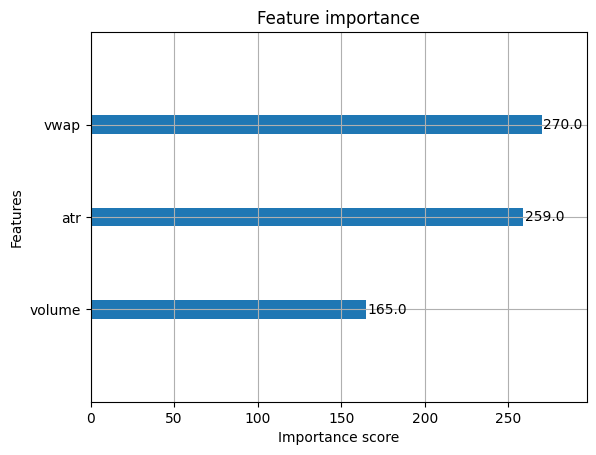

In [58]:
xgb.plot_importance(model)
plt.show()

In [59]:
# Correlation with target
correlations = df[features + ["target"]].corr()["target"].drop("target")
print(correlations.sort_values(ascending=True))

volume    0.065549
atr       0.171774
vwap      0.238607
Name: target, dtype: float64
